<a href="https://colab.research.google.com/github/ValenDiazzz/MachineLearning/blob/main/DecisionTree_FixedTermBankDepo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#   Subscription to Fixed-Term Bank Deposits

Data collected from: https://archive.ics.uci.edu/dataset/222/bank+marketing

The goal is to predict if an individual will subscribe to a fixed-term deposit in a bank.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import cohen_kappa_score

## Data Preparation

In [ ]:
data= pd.read_csv("bank-full.csv", sep=";")

In [ ]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
data.shape

(45211, 17)

In [ ]:
n_Yes= data[data['y']=='yes'].shape[0]
n_No= data[data['y']=='no'].shape[0]
prop_Yes= n_Yes/(n_No+n_Yes)
prop_No= 1 - prop_Yes
print(f"Category 'Yes':{n_Yes}  Proportion:{prop_Yes}")
print(f"Category 'No':{n_No}  Proportion:{prop_No}")

Category 'Yes':5289  Proportion:0.11698480458295547
Category 'No':39922  Proportion:0.8830151954170445


In [ ]:
missing_val_col= ['contact','pdays','poutcome']
data= data.drop(missing_val_col, axis=1)

In [ ]:
data.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,previous,y
0,58,management,married,tertiary,no,2143,yes,no,5,may,261,1,0,no
1,44,technician,single,secondary,no,29,yes,no,5,may,151,1,0,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,76,1,0,no
3,47,blue-collar,married,unknown,no,1506,yes,no,5,may,92,1,0,no
4,33,unknown,single,unknown,no,1,no,no,5,may,198,1,0,no


In [ ]:
binary_mapper = {'no': False, 'yes': True}

binary_col= ['default','housing','loan']
for col in binary_col:
    data[col]= data[col].replace(binary_mapper)
data.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,previous,y
0,58,management,married,tertiary,False,2143,True,False,5,may,261,1,0,no
1,44,technician,single,secondary,False,29,True,False,5,may,151,1,0,no
2,33,entrepreneur,married,secondary,False,2,True,True,5,may,76,1,0,no
3,47,blue-collar,married,unknown,False,1506,True,False,5,may,92,1,0,no
4,33,unknown,single,unknown,False,1,False,False,5,may,198,1,0,no


In [ ]:
data.month = pd.to_datetime(data.month, format='%b').dt.month

In [ ]:
categorical_col=['job','marital','education']
data= data.drop(categorical_col, axis=1)
data.head()

,age,default,balance,housing,loan,day,month,duration,campaign,previous,y
0,58,False,2143,True,False,5,5,261,1,0,no
1,44,False,29,True,False,5,5,151,1,0,no
2,33,False,2,True,True,5,5,76,1,0,no
3,47,False,1506,True,False,5,5,92,1,0,no
4,33,False,1,False,False,5,5,198,1,0,no


In [ ]:
random_rows= random.sample(range(n_No), n_No-10000)
No_rows=data[data['y']=='no'].index
delete_No_rows= [No_rows[i] for i in random_rows]
data= data.drop(delete_No_rows)

In [ ]:
data.shape

(15289, 11)

## Decision Tree Classification and Analysis

In [ ]:
X, y= data.iloc[:,:-1], data.iloc[:,-1]
X_train,X_test, y_train, y_test= train_test_split(X,y,test_size=0.2)
X_train,X_val, y_train, y_val= train_test_split(X_train,y_train,test_size=0.25)

In [ ]:
print(f"Train set samples:{X_train.shape[0]}")
print(f"Test set samples:{X_test.shape[0]}")
print(f"Validation set samples:{X_val.shape[0]}")

Train set samples:9173
Test set samples:3058
Validation set samples:3058


In [ ]:
model= DecisionTreeClassifier(criterion='entropy')
path= model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [ ]:
models = []
for ccp_alpha in ccp_alphas:
    model = DecisionTreeClassifier(criterion='entropy',ccp_alpha=ccp_alpha)
    model.fit(X_train, y_train)
    models.append(model)

# Calcular el número de nodos y la profundidad del árbol
node_counts = [model.tree_.node_count for model in models]
depth = [model.tree_.max_depth for model in models]

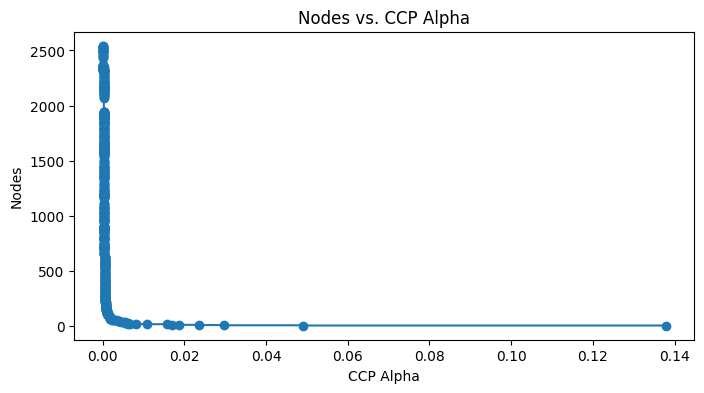

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
plt.xlabel("CCP Alpha")
plt.ylabel("Nodes")
plt.title("Nodes vs. CCP Alpha")
plt.show()

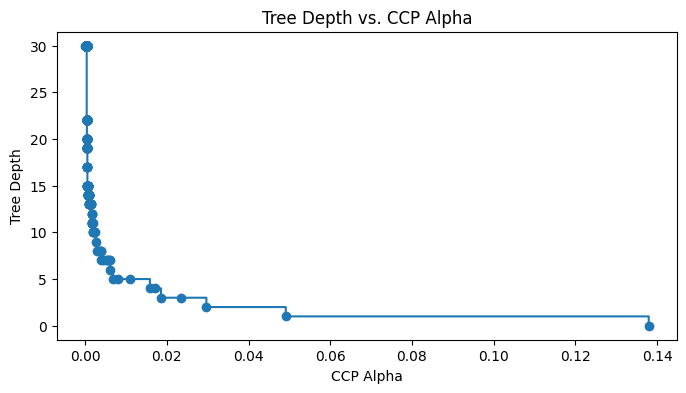

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
plt.xlabel("CCP Alpha")
plt.ylabel("Tree Depth")
plt.title("Tree Depth vs. CCP Alpha")
plt.show()

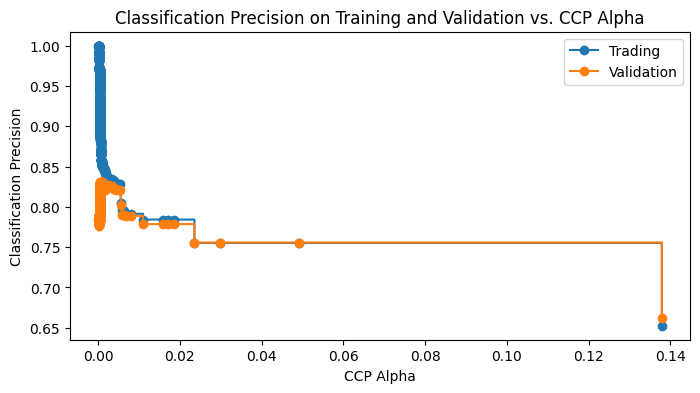

In [ ]:
train_accuracy = [accuracy_score(y_train, model.predict(X_train)) for model in models]
validation_accuracy = [accuracy_score(y_val, model.predict(X_val)) for model in models]

plt.figure(figsize=(8, 4))
plt.plot(ccp_alphas, train_accuracy, marker='o', label='Trading', drawstyle="steps-post")
plt.plot(ccp_alphas, validation_accuracy, marker='o', label='Validation', drawstyle="steps-post")
plt.xlabel("CCP Alpha")
plt.ylabel("Classification Precision")
plt.title("Classification Precision on Training and Validation vs. CCP Alpha")
plt.legend()
plt.show()

In [ ]:
print(f"{len(ccp_alphas)} trees were trained")

616 trees were trained


In [ ]:
arg= np.argmax(validation_accuracy)
print(f"The best accuracy on validation is: {max(validation_accuracy)} with ccp_alpha= {ccp_alphas[arg]}")
print(f"Tree depth: {depth[arg]}")

The best accuracy on validation is: 0.8306082406801831 with ccp_alpha= 0.0005472092018591385
Tree depth: 19


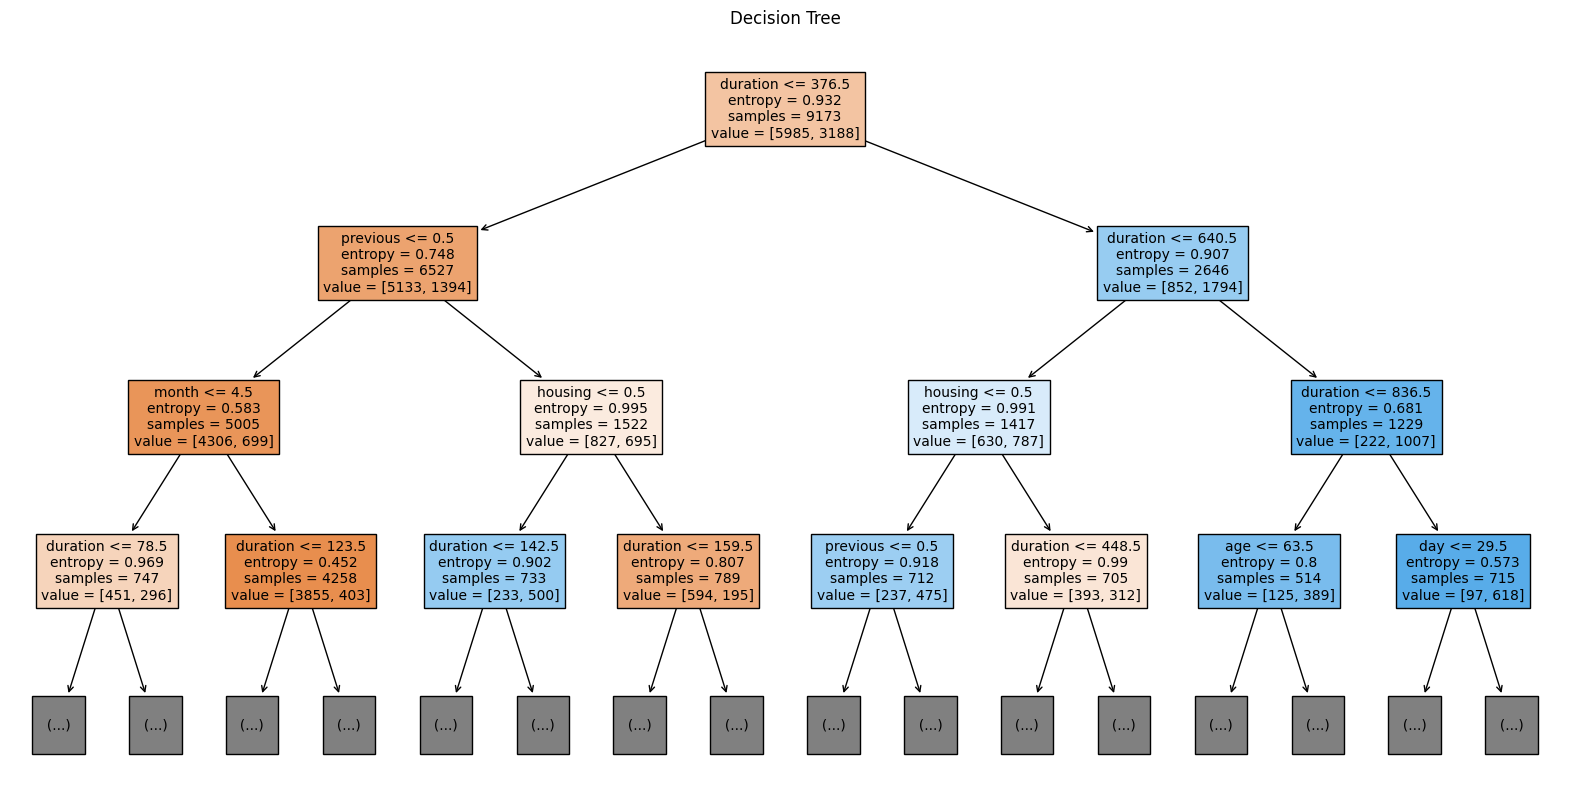

In [ ]:
plt.style.use("default")
plt.figure(figsize=(20, 10))
plot_tree(models[arg], filled=True, max_depth=3,fontsize=10, feature_names= data.columns[:-1].to_list())
plt.title("Decision Tree")
plt.show()

## Results

In [ ]:
y_pred= models[arg].predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          no       0.88      0.85      0.87      1990
         yes       0.74      0.79      0.76      1068

    accuracy                           0.83      3058
   macro avg       0.81      0.82      0.81      3058
weighted avg       0.83      0.83      0.83      3058



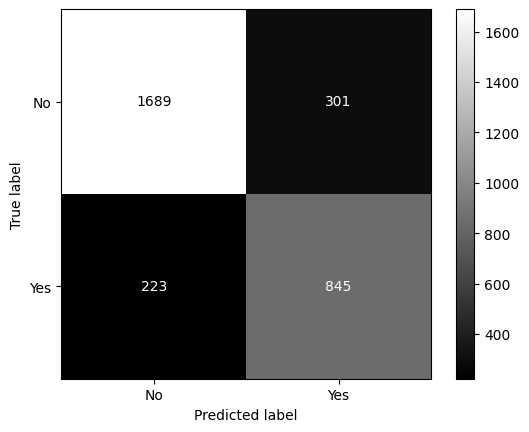

In [ ]:
labels= ["No", "Yes"]
cm= confusion_matrix(y_test, y_pred)
ConfMtx= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
ConfMtx.plot(cmap='gray')

No parece haber overfitting. Los diferentes scores son aceptables aun en la clase con menor cantidad de datos.

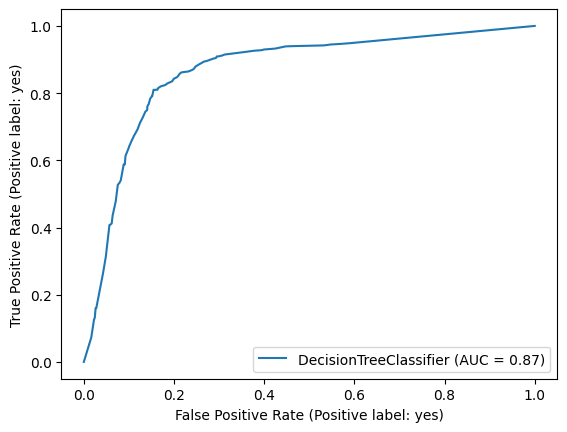

In [ ]:
roc_display = RocCurveDisplay.from_estimator(models[arg], X_test, y_test)